In [1]:
from torch.utils.data import DataLoader
from dataset import MNISTDataset
from model_trainer import deep_feature_reweighting, train
from models import SimpleModel
from spurious_features import Position, spurious_square
import torch

In [2]:
train_dataset = MNISTDataset(
    train=True,
    labels=[9, 7],
    spurious_features={
        9: lambda img: spurious_square(img, pos=Position.LEFT_TOP, size=5),
        7: lambda img: spurious_square(img, pos=Position.RIGHT_BOTTOM, size=5),
    },
    probabilities={9: 0.95, 7: 0.95},
)

same_validation_dataset = MNISTDataset(
    train=False,
    labels=[9, 7],
    spurious_features={
        9: lambda img: spurious_square(img, pos=Position.LEFT_TOP, size=5),
        7: lambda img: spurious_square(img, pos=Position.RIGHT_BOTTOM, size=5),
    },
    probabilities={9: 0.95, 7: 0.95},
)

opposite_validation_dataset = MNISTDataset(
    train=False,
    labels=[9, 7],
    spurious_features={
        9: lambda img: spurious_square(img, pos=Position.RIGHT_BOTTOM, size=5),
        7: lambda img: spurious_square(img, pos=Position.LEFT_TOP, size=5),
    },
    probabilities={9: 0.95, 7: 0.95},
)

non_spurious_validation_dataset = MNISTDataset(
    train=False,
    labels=[9, 7],
)

# TODO
# only spurious dataset = MNISTDataset()

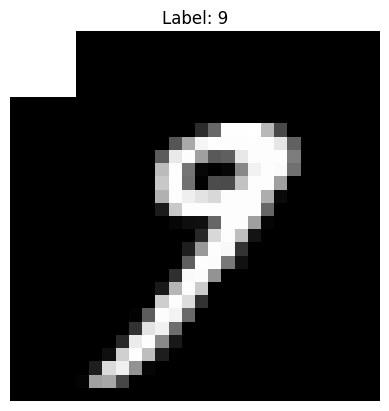

In [3]:
train_dataset.view_item(5)

In [4]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

validation_dataloaders = {
    "Unbiased": DataLoader(
        non_spurious_validation_dataset, batch_size=64, shuffle=False
    ),
    "Spurious": DataLoader(same_validation_dataset, batch_size=64, shuffle=False),
    "Opposite": DataLoader(opposite_validation_dataset, batch_size=64, shuffle=False),
}

In [5]:
model = SimpleModel(num_classes=2)

model_path, tensorboard_path = train(
    model=model,
    validation_loaders=validation_dataloaders,
    train_loader=train_loader,
    num_epochs=15,
    optimizer_type=torch.optim.SGD,
    lr=0.001,
)

Epochs: 100%|██████████| 15/15 [00:29<00:00,  1.98s/it, Train Loss=0.0265, Valid Loss Unbiased=0.423, Valid Loss Spurious=0.0249, Valid Loss Opposite=3.93, Train Accuracy=99.40%, Valid Accuracy Unbiased=0.894, Valid Accuracy Spurious=0.995, Valid Accuracy Opposite=0.0447, Valid Worst Group Accuracy Unbiased=0.857, Valid Worst Group Accuracy Spurious=0.882, Valid Worst Group Accuracy Opposite=0]


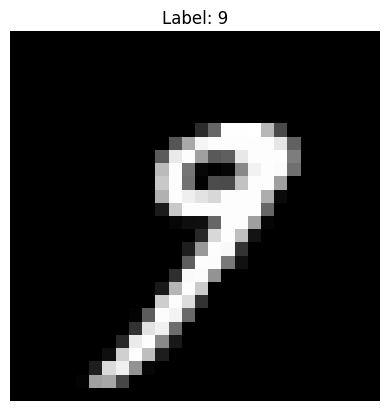

In [6]:
dfr_train_set = MNISTDataset(train=True, labels=[9, 7])
dfr_loader = DataLoader(dfr_train_set, batch_size=64, shuffle=True)
dfr_train_set.view_item(5)

In [7]:
model_path, tensorboard_path = deep_feature_reweighting(
    path_to_model=model_path,
    path_to_tensorboard_run=tensorboard_path,
    model=model,
    num_epochs=5,
    validation_loaders=validation_dataloaders,
    train_loader=dfr_loader,
    optimizer_type=torch.optim.SGD,
    lr=0.001,
)

Reweighting Epochs: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it, Train Loss=0.4131, Valid Loss Unbiased=0.395, Valid Loss Spurious=0.021, Valid Loss Opposite=4.56, Train Accuracy=87.97%, Valid Accuracy Unbiased=0.895, Valid Accuracy Spurious=0.995, Valid Accuracy Opposite=0.0447, Valid Worst Group Accuracy Unbiased=0.854, Valid Worst Group Accuracy Spurious=0.902, Valid Worst Group Accuracy Opposite=0] 


In [8]:
tensorboard_path

'runs/29_11_2024_1248'